# [프로젝트] 수도권 생활이동 현황 분석하기

---

## 프로젝트 개요

매일 아침 출근길에 오르며 "이 많은 사람들이 도대체 어디서 온 걸까?"라는 생각, 해본 적 있지 않나요? 서울과 수도권을 오가는 수많은 사람들의 발걸음 속엔 어떤 패턴이 숨겨져 있을까요?

> "자치구 간 이동 인구는 어디가 가장 많을까?"   
"출근길 평균 이동 시간은 어느 지역이 가장 길까?"   
"주말이면 어디로 쇼핑을 많이 갈까?"   

이번 프로젝트에서는 수도권 생활이동 데이터를 통해 사람들의 실제 이동 흐름을 살펴봅니다.   
데이터 전처리부터 분석, 시각화까지 직접 해보며 도시 속 숨은 이동 패턴을 함께 찾아보아요!

---

## 프로젝트 목표

- 수도권 생활이동 데이터를 활용하여 자치구별 유입/유출 인구 흐름, 이동 목적별 평균 거리/시간 등을 분석
- 탐색적 데이터 분석을 수행하기 위한 데이터 정제, 시각화 방법 및 통계 기초 학습

---

## 데이터 출처

서울 열린데이터 광장 - 수도권 생활이동 (출발-도착지 기준)   
https://data.seoul.go.kr/dataList/OA-22300/F/1/datasetView.do   

서울 열린데이터 광장 - 전국 행정동 코드정보    
https://data.seoul.go.kr/dataVisual/seoul/capitalRegionLivingMigration.do

---

## 목차

1. 데이터 읽기   
2. 데이터 정제하기   
3. 데이터 분석하기     
    3.1. 시간대별 이동 인구수 분포 분석     
    3.2. 이동 목적별 평균 이동 거리 및 시간 분석    
    3.3. 서울과 그 외 지역의 생활 이동 인구 비교     
    3.4. 서울 자치구 간 이동 흐름 시각화     
    3.5. 내국인과 외국인의 이동 패턴 비교     
    3.6. 출근 지역별 평균 이동 거리/시간 분석       
    3.7. 이동 목적별 평일 vs 주말 이동 인구수 비교    
4. 퀴즈 제출하기


---

## 1. 데이터 읽기

### 1.1. 데이터 불러오기

이번 프로젝트에 필요한 라이브러리를 불러옵니다.

In [63]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('font', family='AppleGothic')
import folium
from folium import plugins
from math import radians, cos, sin, asin, sqrt
import seaborn as sns
import numpy as np

수도권 생활이동 데이터 중 2025년 2월 24일 자료를 `DataFrame`으로 저장합니다.   
용량이 크기 때문에 다소 시간이 걸릴 수 있습니다. (약 30초)

In [12]:
# CSV 파일을 읽고 DataFrame으로 저장
mobility_df = pd.read_csv("data/seoul_purpose_admdong3_final_20250224.csv", encoding='utf-8')

`mobility_df`에 잘 저장되었는지 확인해볼까요?    
상위 5개 행과 각 컬럼 정보를 살펴봅시다.

In [ ]:
# 상위 5개 행 확인
mobility_df.head(5)

,o_admdong_cd,d_admdong_cd,st_time_cd,fns_time_cd,in_forn_div_nm,forn_citiz_nm,move_purpose,move_dist,move_time,cnt,etl_ymd
0,11110515.0,11110515.0,0,0,내국인,ㆍ값없음,3,461.0,1.481667,2.35,20250224
1,11110515.0,11110515.0,0,0,단기외국인,ㆍ값없음,3,696.4,1.923333,3.50,20250224
2,11110515.0,11110515.0,0,0,내국인,한국,7,368.3,4.296111,8.19,20250224
3,11110515.0,11110530.0,0,0,내국인,한국,7,461.0,2.718333,2.65,20250224
4,11110515.0,11110615.0,0,0,내국인,한국,3,403.1,3.488333,2.55,20250224


In [41]:
# 각 컬럼과 타입 정보 확인
mobility_df.info(verbose=True)
mobility_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10844227 entries, 0 to 10844226
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   o_admdong_cd    float64
 1   d_admdong_cd    float64
 2   st_time_cd      int64  
 3   fns_time_cd     int64  
 4   in_forn_div_nm  object 
 5   forn_citiz_nm   object 
 6   move_purpose    int64  
 7   move_dist       float64
 8   move_time       float64
 9   cnt             float64
 10  etl_ymd         int64  
dtypes: float64(5), int64(4), object(2)
memory usage: 910.1+ MB


o_admdong_cd      0
d_admdong_cd      0
st_time_cd        0
fns_time_cd       0
in_forn_div_nm    0
forn_citiz_nm     0
move_purpose      0
move_dist         0
move_time         0
cnt               0
etl_ymd           0
dtype: int64

10844780개의 행과 11개의 열로 이루어진 것을 확인할 수 있습니다.   
다음 섹션에서는 각 컬럼이 어떤 데이터를 나타내는지 자세히 살펴보겠습니다.

---

### 1.2. 데이터 확인하기

앞서 `mobility_df.info()`로 살펴본 것만으로는 아직 각 컬럼과 값이 정확히 무엇을 나타내는지, 분석에 의미가 있는 데이터인지 알기 어렵습니다.   
이제부터 각 컬럼의 값 타입과 분포를 살펴보며 **분석에 용이한 형태로 어떻게 정제하면 좋을 지** 고민해볼까요?

- `O_ADMDONG_CD`:	출발 행정동	  
- `D_ADMDONG_CD`:	도착 행정동	  
- `ST_TIME_CD`:	출발 시간 7 ~ 9시 / 17시 ~ 19시는 20분단위, 그 외 1시간 단위   
- `FNS_TIME_CD`:	도착 시간 7 ~ 9시 / 17시 ~ 19시는 20분단위, 그 외 1시간 단위   
- `IN_FORN_DIV_NM`:	내/외국인 구분   
- `FORN_CITIZ_NM`:	국적   
- `MOVE_PURPOSE`:	이동 목적 1: 출근, 2 : 등교, 3: 귀가, 4: 쇼핑, 5: 관광, 6: 병원, 7: 기타   
- `MOVE_DIST`:	평균 이동 거리(m)   
- `MOVE_TIME`:	평균 이동 시간(분)   
- `CNT`:	이동인구 수    
- `ETL_YMD`:	기준 년월 일  

먼저 출발/도착 행정동 관련 컬럼을 살펴보겠습니다.

In [21]:
# o_admdong_cd 컬럼의 고유값 확인
unique_values = mobility_df['o_admdong_cd'].unique()

print(f"타입: {mobility_df['o_admdong_cd'].dtype}")
print(f"전체 고유값 개수: {len(unique_values)}")
print("상위 10개 고유값:")
for val in unique_values[:10]:
    print(val)

타입: float64
전체 고유값 개수: 3515
상위 10개 고유값:
11110515.0
11110530.0
11110540.0
11110550.0
11110560.0
11110570.0
11110580.0
11110600.0
11110615.0
11110630.0


In [18]:
# d_admdong_cd 컬럼의 고유값 확인
unique_values = mobility_df['d_admdong_cd'].unique()

print(f"타입: {mobility_df['d_admdong_cd'].dtype}")
print(f"전체 고유값 개수: {len(unique_values)}")
print("상위 10개 고유값:")
for val in unique_values[:10]:
    print(val)

타입: float64
전체 고유값 개수: 3508
상위 10개 고유값:
11110515.0
11110530.0
11110615.0
11110650.0
11140550.0
11440555.0
11110580.0
11290555.0
11305603.0
11380530.0


`o_admdong_cd`과 `d_admdong_cd`에는 출발/도착 행정동의 코드정보가 숫자 형태로 담겨있습니다.   
코드정보만으로는 실제 어떤 '시도'와 '시군구'에 해당하는지 직관적으로 알기 어렵네요.   
행정동 코드 정보 데이터를 불러와 각 코드가 어떤 지역에 해당하는 지 확인해봅시다.



In [22]:
# 행정동 코드 정보 확인
admin_df = pd.read_csv("data/ADMI_202502.csv", encoding='utf-8')
admin_df.head()

,SIDO_NM,SGG_NM,ADMI_NM,ADMI_CD,FULL_NM,BASE_YM
0,서울특별시,종로구,청운효자동,11110515,서울특별시 종로구 청운효자동,202502
1,서울특별시,종로구,사직동,11110530,서울특별시 종로구 사직동,202502
2,서울특별시,종로구,삼청동,11110540,서울특별시 종로구 삼청동,202502
3,서울특별시,종로구,부암동,11110550,서울특별시 종로구 부암동,202502
4,서울특별시,종로구,평창동,11110560,서울특별시 종로구 평창동,202502


`admin_df`의 `ADMI_CD`에 행정동 코드가 담겨있으니, 앞으로 이 정보를 활용하여 **`mobility_df`의 코드정보를 분석하기 쉬운 '시도'와 '시군구' 텍스트로 변경**할 수 있겠네요!

이번에는 출발/도착 시간 관련 컬럼을 살펴보겠습니다.

In [23]:
# st_time_cd 컬럼의 고유값 확인
unique_values = mobility_df['st_time_cd'].unique()

print(f"타입: {mobility_df['st_time_cd'].dtype}")
print(f"전체 고유값 개수: {len(unique_values)}")
print(f"고유값: {unique_values}")

타입: int64
전체 고유값 개수: 36
고유값: [   0    1    2    3    4    5    6  700  720  740  800  820  840  900
  920  940   10   11   12   13   14   15   16 1700 1720 1740 1800 1820
 1840 1900 1920 1940   20   21   22   23]


In [26]:
# fns_time_cd 컬럼의 고유값 확인
unique_values = mobility_df['fns_time_cd'].unique()

print(f"타입: {mobility_df['fns_time_cd'].dtype}")
print(f"전체 고유값 개수: {len(unique_values)}")
print(f"고유값: {unique_values}")

타입: int64
전체 고유값 개수: 36
고유값: [   0    1    2    3    4    5    6  700  720  740  800  820  840  900
  920  940   10   11   12   13   14   15   16 1700 1720 1740 1800 1820
 1840 1900 1920 1940   20   21   22   23]


출발/도착 시간이 정수 형태로 표현되어 있습니다.
- 3 → 03:00
- 700 → 07:00
- 1840 → 18:40   

7 ~ 9시 및 17시 ~ 19시의 경우는 20분 단위로 나누어지고, 그 외 시간은 1시간 단위로 구분되어 있네요.  
자리수가 제각각으로 되어 있어 직관적이지 않으니, 앞으로 **시간 형식을 일정하게 통일**하는 것이 좋겠습니다. 

이번에는 내/외국인 구분과 관련한 컬럼을 살펴볼까요?

In [27]:
# in_forn_div_nm 컬럼의 고유값 확인
unique_values = mobility_df['in_forn_div_nm'].unique()

print(f"타입: {mobility_df['in_forn_div_nm'].dtype}")
print(f"전체 고유값 개수: {len(unique_values)}")
print(f"고유값: {unique_values}")

타입: object
전체 고유값 개수: 3
고유값: ['내국인' '단기외국인' '장기외국인']


In [29]:
# forn_citiz_nm 컬럼의 고유값 확인
unique_values = mobility_df['forn_citiz_nm'].unique()

print(f"타입: {mobility_df['forn_citiz_nm'].dtype}")
print(f"전체고유값개수 : {len(unique_values)}")
print("상위 10개 고유값:")
for val in unique_values[:10]:
    print(val)

타입: object
전체고유값개수 : 249
상위 10개 고유값:
ㆍ값없음
한국
중국
베트남
UN
네팔
홍콩
파키스탄
일본
우즈베키스탄


크게 내국인/외국인으로 구분되며, 외국인의 경우 세분화된 국가가 표시되어 있습니다.

다음으로 이동 목적과 관련한 컬럼을 살펴보겠습니다.

In [30]:
# move_purpose 컬럼의 고유값 확인
unique_values = mobility_df['move_purpose'].unique()

print(f"타입: {mobility_df['move_purpose'].dtype}")
print(f"전체 고유값 개수: {len(unique_values)}")
print(f"고유값: {unique_values}")

타입: int64
전체 고유값 개수: 7
고유값: [3 7 1 6 2 4 5]


이동 목적은 숫자로 라벨링되어 있는데, 각각 `1: 출근, 2 : 등교, 3: 귀가, 4: 쇼핑, 5: 관광, 6: 병원, 7: 기타`를 나타냅니다.   
직관적이지 않으니, 분석에 용이하도록 **숫자를 텍스트로 다시 라벨링**하는 것이 좋겠습니다.

이번에는 평균 이동 거리/시간과 관련한 컬럼을 살펴봅시다.

In [31]:
# move_dist 컬럼의 고유값 확인 (단위: m)
unique_values = mobility_df['move_dist'].unique()

print(f"타입: {mobility_df['move_dist'].dtype}")
print(f"전체 고유값 개수: {len(unique_values)}")
print("상위 10개 고유값:")
for val in unique_values[:10]:
    print(val)

타입: float64
전체 고유값 개수: 1417694
상위 10개 고유값:
461.0
696.4
368.3
403.1
961.8
2491.0
2083.9
3893.9
1619.4
134.95


In [32]:
# move_time 컬럼의 고유값 확인 (단위: 분)
unique_values = mobility_df['move_time'].unique()

print(f"타입: {mobility_df['move_time'].dtype}")
print(f"전체 고유값 개수: {len(unique_values)}")
print("상위 10개 고유값:")
for val in unique_values[:10]:
    print(val)

타입: float64
전체 고유값 개수: 859223
상위 10개 고유값:
1.481666666666667
1.9233333333333331
4.296111111111112
2.7183333333333333
3.4883333333333337
16.705
11.118333333333334
14.613333333333332
7.078333333333333
18.603333333333335


평균 이동거리의 단위는 `m`이고, 평균 이동시간의 단위는 `분`입니다.

다음으로는 이동 인구 수를 나타내는 컬럼을 확인해볼까요?

In [33]:
# cnt 컬럼의 고유값 확인 (단위: 명)
unique_values = mobility_df['cnt'].unique()

print(f"타입: {mobility_df['cnt'].dtype}")
print(f"전체 고유값 개수: {len(unique_values)}")
print("상위 10개 고유값:")
for val in unique_values[:10]:
    print(val)

타입: float64
전체 고유값 개수: 20146
상위 10개 고유값:
2.35
3.5
8.19
2.65
2.55
3.13
3.04
2.83
7.25
21.33


보정된 이동 인구 수이기 떄문에 `int`가 아닌 `float`로 표현되어있는 것을 확인할 수 있습니다.

마지막으로 기준연월일을 나타내는 컬럼을 살펴봅시다.

In [34]:
# etl_ymd 컬럼의 고유값 확인 (단위: 연월일)
unique_values = mobility_df['etl_ymd'].unique()

print(f"타입: {mobility_df['etl_ymd'].dtype}")
print(f"전체 고유값 개수: {len(unique_values)}")
print("상위 10개 고유값:")
print(unique_values)

타입: int64
전체 고유값 개수: 1
상위 10개 고유값:
[20250224]


2025년 2월 24일 자료를 불러왔기 때문에 기준연월일은 전부 `20250224`인 것을 확인할 수 있습니다.   
해당 날짜의 데이터 안에서 분석할 예정이므로, 크게 의미가 없는 이 컬럼은 지워도 좋을 것 같네요!

이렇게 11개의 컬럼을 자세히 살펴보았습니다.    
이제 수도권 생활이동 데이터가 어떻게 구성되어 있는지 이해가 되었나요?   
그럼 잘 이해했는지 간단히 점검해봅시다! 아래의 행은 어떻게 해석할 수 있을까요? 

In [35]:
# 특정 행 출력
mobility_df.loc[2000000]

o_admdong_cd      11230570.0
d_admdong_cd      11110615.0
st_time_cd               740
fns_time_cd              900
in_forn_div_nm           내국인
forn_citiz_nm             한국
move_purpose               1
move_dist             7120.6
move_time          79.596667
cnt                     2.93
etl_ymd             20250224
Name: 2000000, dtype: object

> 2025년 2월 24일에 `11110515(서울특별시 동대문구 전농2동)`에서 `07:40`에 출발하여 `11110615(서울특별시 종로구 종로1.2.3.4가동)`에 `09:00`에 도착한 `출근` 목적의 `내국인`의 평균 이동 거리는 `7120.6`m이고, 평균 이동 시간은 `79.6`분이며 이동 인구 수는 `2.93`명이다.

그리고 데이터를 어떻게 정제하면 좋을지 생각해본 포인트를 다시 정리하자면,
- 행정동 코드번호를 '시도' 및 '시군구' 텍스트로 변환
- 출도착 시간 형식 통일
- 숫자로 된 이동 목적 라벨을 텍스트로 변환   

다음 섹션에서는 위 내용에 기반하여 데이터를 분석에 용이하도록 직접 정제해보도록 하겠습니다.

---

## 2. 데이터 정제하기

### 2.1. 결측값 제거

먼저, 데이터 내 결측값이 포함된 행을 전부 제거해줍니다.

In [36]:
# 결측값 제거 및 인덱스 리셋
mobility_df = mobility_df.dropna().reset_index(drop=True)

In [37]:
# 데이터 정보 확인
mobility_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10844227 entries, 0 to 10844226
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   o_admdong_cd    float64
 1   d_admdong_cd    float64
 2   st_time_cd      int64  
 3   fns_time_cd     int64  
 4   in_forn_div_nm  object 
 5   forn_citiz_nm   object 
 6   move_purpose    int64  
 7   move_dist       float64
 8   move_time       float64
 9   cnt             float64
 10  etl_ymd         int64  
dtypes: float64(5), int64(4), object(2)
memory usage: 910.1+ MB


결측값 제거 전과 비교하여 10844780개 → 10844227로 결측값이 포함된 553개의 행이 지워졌습니다. 

---

### 2.2. 행정동 코드정보 매핑

이번에는 행정동 코드정보를 텍스트로 매핑해보도록 하겠습니다.    
예를 들어 `11110515` → `서울특별시`, `종로구`, `청운효자동`과 같이 세분화된 컬럼으로 변환합니다.   

>📌 `map()`은 Series의 각 요소에 함수를 적용하거나, 매핑 딕셔너리를 이용해 값을 대응시켜 변환하는 데 사용됩니다. 

In [50]:
# 매핑용 시리즈 생성
# print(admin_df.head())
admi_to_sido = admin_df.set_index('ADMI_CD')['SIDO_NM']  # 시도
# print(admi_to_sido.head())
admi_to_sgg = admin_df.set_index('ADMI_CD')['SGG_NM']  # 시군구
# print(admi_to_sgg.head())
admi_to_admi = admin_df.set_index('ADMI_CD')['ADMI_NM']  # 동

# 출발지 정보 매핑
# o_admdong_cd에 해당하는 '시도', '시군구', '동'을 각각 새로운 컬럼으로 만들어 저장합니다.
print(mobility_df.head())
mobility_df['o_SIDO'] = mobility_df['o_admdong_cd'].map(admi_to_sido)  # o_SIDO: 출발지 시도
mobility_df['o_SGG'] = mobility_df['o_admdong_cd'].map(admi_to_sgg)  # o_SIDO: 출발지 시군구
mobility_df['o_ADMI'] = mobility_df['o_admdong_cd'].map(admi_to_admi)  # o_SIDO: 출발지 동

# 도착지 정보 매핑
# d_admdong_cd에 해당하는 '시도', '시군구', '동'을 각각 새로운 컬럼으로 만들어 저장합니다.
mobility_df['d_SIDO'] = mobility_df['d_admdong_cd'].map(admi_to_sido)  # d_SIDO: 도착지 시도
mobility_df['d_SGG'] = mobility_df['d_admdong_cd'].map(admi_to_sgg)  # d_SGG: 도착지 시군구
mobility_df['d_ADMI'] = mobility_df['d_admdong_cd'].map(admi_to_admi)  # d_ADMI: 도착지 동
print(mobility_df.head())

   o_admdong_cd  d_admdong_cd  st_time_cd  fns_time_cd in_forn_div_nm  \
0    11110515.0    11110515.0           0            0            내국인   
1    11110515.0    11110515.0           0            0          단기외국인   
2    11110515.0    11110515.0           0            0            내국인   
3    11110515.0    11110530.0           0            0            내국인   
4    11110515.0    11110615.0           0            0            내국인   

  forn_citiz_nm  move_purpose  move_dist  move_time   cnt   etl_ymd o_SIDO  \
0          ㆍ값없음             3      461.0   1.481667  2.35  20250224  서울특별시   
1          ㆍ값없음             3      696.4   1.923333  3.50  20250224  서울특별시   
2            한국             7      368.3   4.296111  8.19  20250224  서울특별시   
3            한국             7      461.0   2.718333  2.65  20250224  서울특별시   
4            한국             3      403.1   3.488333  2.55  20250224  서울특별시   

  o_SGG o_ADMI d_SIDO d_SGG       d_ADMI  
0   종로구  청운효자동  서울특별시   종로구        청운효자동  
1   종로

이제 필요없는 `o_admdong_cd`, `d_admdong_cd`, `etl_ymd` 컬럼은 지우고, 확인하기에 편리하도록 컬럼 순서를 재정렬합니다.

In [51]:
# 컬럼 순서 재정렬
new_columns = [
    'o_SIDO', 'o_SGG', 'o_ADMI',
    'd_SIDO', 'd_SGG', 'd_ADMI',
    'st_time_cd', 'fns_time_cd', 'in_forn_div_nm',
    'forn_citiz_nm', 'move_purpose', 'move_dist',
    'move_time', 'cnt'
]

mobility_df = mobility_df[new_columns]

In [52]:
# 상위 데이터 5개 확인
mobility_df.head()

,o_SIDO,o_SGG,o_ADMI,d_SIDO,d_SGG,d_ADMI,st_time_cd,fns_time_cd,in_forn_div_nm,forn_citiz_nm,move_purpose,move_dist,move_time,cnt
0,서울특별시,종로구,청운효자동,서울특별시,종로구,청운효자동,0,0,내국인,ㆍ값없음,3,461.0,1.481667,2.35
1,서울특별시,종로구,청운효자동,서울특별시,종로구,청운효자동,0,0,단기외국인,ㆍ값없음,3,696.4,1.923333,3.50
2,서울특별시,종로구,청운효자동,서울특별시,종로구,청운효자동,0,0,내국인,한국,7,368.3,4.296111,8.19
3,서울특별시,종로구,청운효자동,서울특별시,종로구,사직동,0,0,내국인,한국,7,461.0,2.718333,2.65
4,서울특별시,종로구,청운효자동,서울특별시,종로구,종로1.2.3.4가동,0,0,내국인,한국,3,403.1,3.488333,2.55


이제 출발/도착 행정동이 더 직관적으로 보이네요!   

---

### 2.3. 출도착 시간 수정

출도착 시간의 형태를 00:00과 같은 형태로 통일하려고 합니다.   
먼저 매핑을 위한 딕셔너리를 생성해둡니다.

In [53]:
# 시간 매핑용 딕셔너리 생성
def generate_time_str_map():
    time_codes = [0, 1, 2, 3, 4, 5, 6,
                  700, 720, 740, 800, 820, 840, 900, 920, 940,
                  10, 11, 12, 13, 14, 15, 16,
                  1700, 1720, 1740, 1800, 1820, 1840, 1900, 1920, 1940,
                  20, 21, 22, 23]

    time_map = {}
    for code in time_codes:
        code_int = int(code)
        if code_int < 100:  # 한 자리 또는 두 자리 숫자 (0~23)
            hour_str = str(code_int).zfill(2)
            time_map[code] = f"{hour_str}:00"
        else:
            code_str = str(code_int).zfill(4)  # 예: 740 → '0740'
            hour = code_str[:2]
            minute = code_str[2:]
            time_map[code] = f"{hour}:{minute}"

    return time_map

time_map = generate_time_str_map()
time_map

{0: '00:00',
 1: '01:00',
 2: '02:00',
 3: '03:00',
 4: '04:00',
 5: '05:00',
 6: '06:00',
 700: '07:00',
 720: '07:20',
 740: '07:40',
 800: '08:00',
 820: '08:20',
 840: '08:40',
 900: '09:00',
 920: '09:20',
 940: '09:40',
 10: '10:00',
 11: '11:00',
 12: '12:00',
 13: '13:00',
 14: '14:00',
 15: '15:00',
 16: '16:00',
 1700: '17:00',
 1720: '17:20',
 1740: '17:40',
 1800: '18:00',
 1820: '18:20',
 1840: '18:40',
 1900: '19:00',
 1920: '19:20',
 1940: '19:40',
 20: '20:00',
 21: '21:00',
 22: '22:00',
 23: '23:00'}

이 딕셔너리에 기반하여 기존 출도착 시간을 새로운 형식으로 변환하고, 필요한 컬럼만 남겨 순서를 재정렬합니다.   
데이터 수가 많으므로 매핑에 다소 시간이 걸릴 수 있습니다.

In [54]:
# 출도착 시간 매핑
# st_time_str, fns_time_str이라는 새로운 컬럼에 저장합니다.
mobility_df['st_time_str'] = mobility_df['st_time_cd'].map(lambda x: time_map.get(int(x), ''))
mobility_df['fns_time_str'] = mobility_df['fns_time_cd'].map(lambda x: time_map.get(int(x), ''))

# 컬럼 순서 재정렬
new_columns = [
    'o_SIDO', 'o_SGG', 'o_ADMI',
    'd_SIDO', 'd_SGG', 'd_ADMI',
    'st_time_str', 'fns_time_str', 'in_forn_div_nm',
    'forn_citiz_nm', 'move_purpose', 'move_dist',
    'move_time', 'cnt'
]

mobility_df = mobility_df[new_columns]

In [55]:
# 상위 데이터 5개 확인
mobility_df.head()

,o_SIDO,o_SGG,o_ADMI,d_SIDO,d_SGG,d_ADMI,st_time_str,fns_time_str,in_forn_div_nm,forn_citiz_nm,move_purpose,move_dist,move_time,cnt
0,서울특별시,종로구,청운효자동,서울특별시,종로구,청운효자동,00:00,00:00,내국인,ㆍ값없음,3,461.0,1.481667,2.35
1,서울특별시,종로구,청운효자동,서울특별시,종로구,청운효자동,00:00,00:00,단기외국인,ㆍ값없음,3,696.4,1.923333,3.50
2,서울특별시,종로구,청운효자동,서울특별시,종로구,청운효자동,00:00,00:00,내국인,한국,7,368.3,4.296111,8.19
3,서울특별시,종로구,청운효자동,서울특별시,종로구,사직동,00:00,00:00,내국인,한국,7,461.0,2.718333,2.65
4,서울특별시,종로구,청운효자동,서울특별시,종로구,종로1.2.3.4가동,00:00,00:00,내국인,한국,3,403.1,3.488333,2.55


In [ ]:
# 출도착 시간 고유값 출력
print(f"출발 시간 고유값: {mobility_df['st_time_str'].unique()}\n")
print(f"도착 시간 고유값: {mobility_df['fns_time_str'].unique()}")

출도착 시간 전부 지정된 형식에 맞게 통일된 것을 확인할 수 있습니다.

---

### 2.4. 이동 목적 매핑

마지막으로, 기존에 숫자로 라벨링된 이동 목적을 텍스트로 변환해볼까요?

In [56]:
# 이동 목적 매핑용 딕셔너리 생성
purpose_map = {
    1: '출근',
    2: '등교',
    3: '귀가',
    4: '쇼핑',
    5: '관광',
    6: '병원',
    7: '기타'
}

# 이동 목적 매핑
mobility_df['move_purpose'] = mobility_df['move_purpose'].map(purpose_map)

In [57]:
# 상위 데이터 5개 확인
mobility_df.head()

,o_SIDO,o_SGG,o_ADMI,d_SIDO,d_SGG,d_ADMI,st_time_str,fns_time_str,in_forn_div_nm,forn_citiz_nm,move_purpose,move_dist,move_time,cnt
0,서울특별시,종로구,청운효자동,서울특별시,종로구,청운효자동,00:00,00:00,내국인,ㆍ값없음,귀가,461.0,1.481667,2.35
1,서울특별시,종로구,청운효자동,서울특별시,종로구,청운효자동,00:00,00:00,단기외국인,ㆍ값없음,귀가,696.4,1.923333,3.50
2,서울특별시,종로구,청운효자동,서울특별시,종로구,청운효자동,00:00,00:00,내국인,한국,기타,368.3,4.296111,8.19
3,서울특별시,종로구,청운효자동,서울특별시,종로구,사직동,00:00,00:00,내국인,한국,기타,461.0,2.718333,2.65
4,서울특별시,종로구,청운효자동,서울특별시,종로구,종로1.2.3.4가동,00:00,00:00,내국인,한국,귀가,403.1,3.488333,2.55


In [ ]:
# 이동 목적 고유값 출력
print(f"이동 목적 고유값: {mobility_df['move_purpose'].unique()}")

`move_purpose` 컬럼이 텍스트로 잘 변환된 것을 확인할 수 있습니다.

분석에 용이하도록 데이터를 정제하는 작업이 모두 완료되었습니다!    
이제부터 본격적으로 수도권 생활이동 현황을 분석해볼까요?

---

## 3. 데이터 분석하기

### 3.1. 시간대별 이동 인구 수 분포 분석

> 🤔 "아침 출근길에 사람이 너무 많아... 몇 시에 출발하면 사람이 좀 적을까?"

출발/도착 시간대별로 그룹화하여 이동 인구 수의 분포를 시각화해봅시다.

먼저 출발 시간대별로 이동 인구 수가 어떻게 되는지 확인해보고 싶습니다.   
우선 간단하게 출발 시간대별로 그룹화하여 이동 인구 수의 합을 구해볼까요? 
>📌 `groupby()`는 특정 컬럼을 기준으로 데이터를 그룹화한 뒤, 각 그룹에 집계, 변환, 필터 등의 연산을 적용할 수 있게 해줍니다.

In [58]:
# 출발 시간대별 이동 인구 수의 합
grouped_st = mobility_df.groupby(["st_time_str"], as_index=False)["cnt"].sum()
grouped_st

,st_time_str,cnt
0,00:00,208523.30
1,01:00,450568.93
2,02:00,360884.95
3,03:00,327074.01
4,04:00,515708.46
5,05:00,1168757.29
6,06:00,2426007.97
7,07:00,1177393.99
8,07:20,1340315.37
9,07:40,1427581.79


7 ~ 9시와 17 ~ 19시만 20분 단위로 세분화가 되어 있어 다른 시간대와 비교하기 어렵네요.   
20분 단위로 세분화되어있는 것들을 전부 정각으로 변환해봅시다.     
시간 데이터의 '분' 정보를 모두 00분으로 통일하면, 예를 들어 7시부터 7시 40분까지의 데이터는 모두 7:00으로 정규화됩니다.

In [59]:
# 출발 시간대 수정
mobility_df["st_time_hr"] = mobility_df["st_time_str"].str.slice(0, 2) + ":00"  # 전부 :00 분으로 통일

이후 groupby를 활용해 출발 시각을 기준으로 이동 인구 수를 합산하면 시간 단위로 이동 인구 수가 집계됩니다

In [60]:
# 출발 시간대별 이동 인구 수의 합
grouped_st = mobility_df.groupby(["st_time_hr"], as_index=False)["cnt"].sum()
grouped_st

,st_time_hr,cnt
0,00:00,208523.30
1,01:00,450568.93
2,02:00,360884.95
3,03:00,327074.01
4,04:00,515708.46
5,05:00,1168757.29
6,06:00,2426007.97
7,07:00,3945291.15
8,08:00,4121257.69
9,09:00,3176782.04


이제 모두 한 시간 간격이 되었고, 20분 단위로 세분화되었던 기록도 정각으로 합쳐졌습니다.   
출발 인구 수는 새벽 5시부터 크게 증가하면서 오전 8시에 정점을 찍네요. 대부분의 사람들이 9시까지 출근하기 위해 이 시간에 가장 많이 움직이는 것 같습니다.

이번에는 도착 시간대별 이동 인구 수의 합도 살펴볼까요?    
마찬가지로 20분 단위로 세분화되어있는 것들을 전부 정각으로 변환시킨 뒤 그룹화해봅시다.

In [61]:
# 도착 시간대 수정
mobility_df["fns_time_hr"] = mobility_df["fns_time_str"].str.slice(0, 2) + ":00"

# 도착 시간대별 이동 인구 수의 합
grouped_fns = mobility_df.groupby(["fns_time_hr"], as_index=False)["cnt"].sum()
grouped_fns

,fns_time_hr,cnt
0,00:00,119443.17
1,01:00,369677.21
2,02:00,380210.19
3,03:00,295128.04
4,04:00,352167.17
5,05:00,552470.52
6,06:00,1444088.81
7,07:00,2810610.67
8,08:00,4612766.51
9,09:00,3540314.90


출발 시간 기준으로는 17:00에 이동 인구가 가장 많았던 반면, 도착 시간 기준으로는 18:00에 이동 인구가 가장 많네요. 

이번에는 출발/도착 시간대별 이동 인구 수의 합을 시각화하여 비교해봅시다.    

>📌 `matplotlib.pyplot`의 `bar()`는 범주형 데이터에 대한 막대그래프를 생성하여 각 값의 크기를 시각적으로 비교할 수 있게 해줍니다.

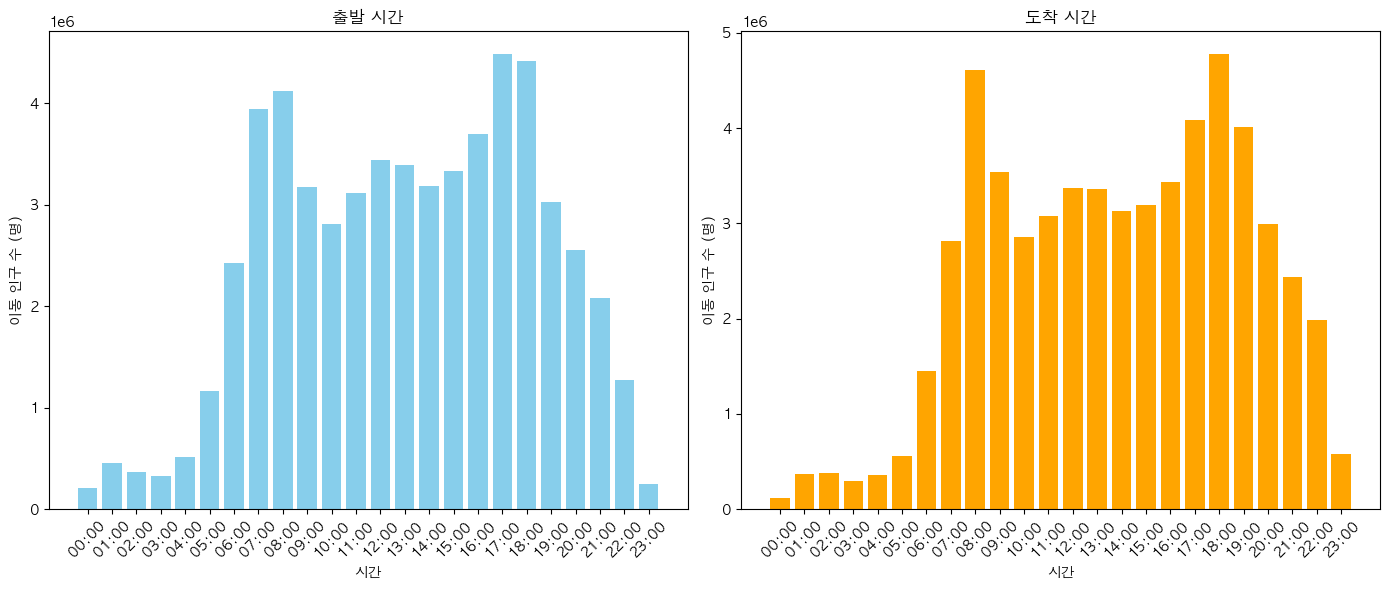

In [ ]:
# 시각화 plot 크기 지정
plt.figure(figsize=(14, 6))

# 첫 번째 subplot - 출발 시간 기준
plt.subplot(1, 2, 1)    # 1행 2열로 그래프를 그릴건데 그중에서 1번째 위치에 그릴거다
plt.bar(grouped_st["st_time_hr"], grouped_st["cnt"], color='skyblue')
plt.title("출발 시간")
plt.xlabel("시간")
plt.ylabel("이동 인구 수 (명)")
plt.xticks(rotation=45)

# 두 번째 subplot - 도착 시간 기준
plt.subplot(1, 2, 2)     # 1행 2열로 그래프를 그릴건데 그중에서 2번째 위치에 그릴거다
plt.bar(grouped_fns["fns_time_hr"], grouped_fns["cnt"], color='orange')
plt.title("도착 시간")
plt.xlabel("시간")
plt.ylabel("이동 인구 수 (명)")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

시각화를 하니 각 시간대별 차이가 확연히 보입니다.    
여기서 y축의 단위는 왼쪽 상단에 1e6(1,000,000)으로 적혀있습니다. 즉 왼쪽 눈금의 값이 1이라면 1,000,000명이라고 해석하면 됩니다.

그런데 출발/도착 두 그래프를 한 눈에 비교하려면 하나의 그래프 안에 값을 나란히 배치하는 게 좋겠네요.

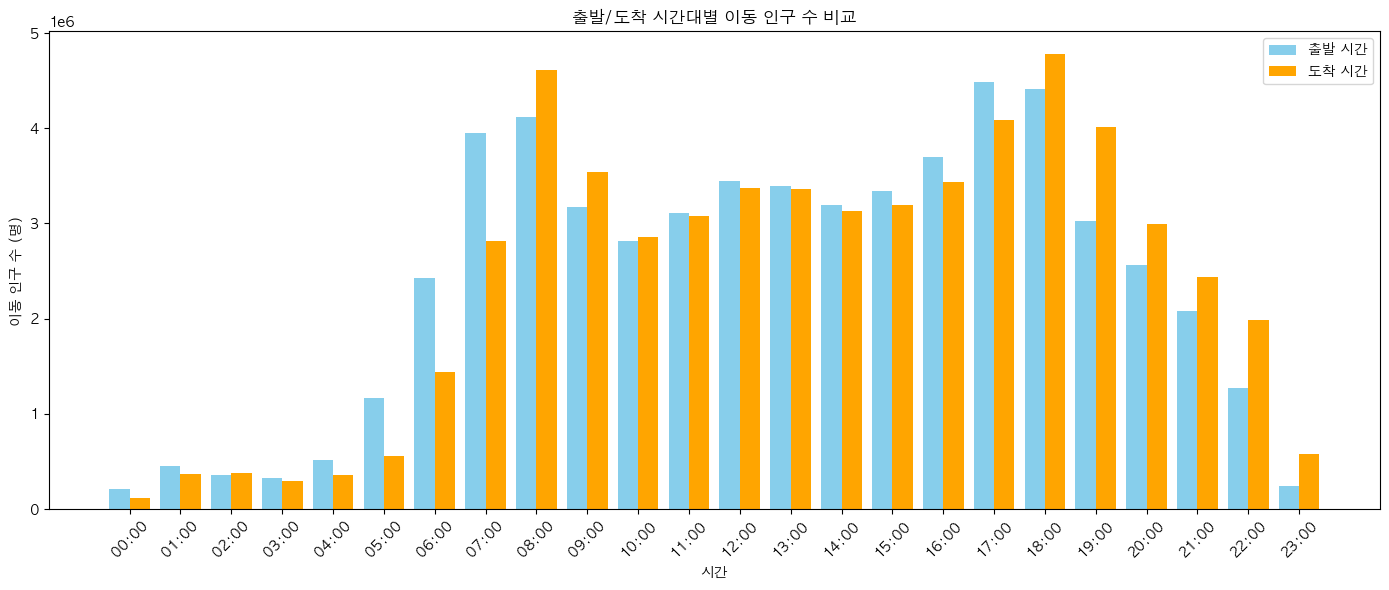

In [65]:
# x축 범위 및 너비 지정
x = np.arange(len(grouped_st["st_time_hr"].unique()))
width = 0.4

# 시각화 plot 크기 지정
plt.figure(figsize=(14, 6))

# 출발 시간 기준 그래프는 x축 정중앙에서 width/2 만큼 왼쪽에 위치
plt.bar(x - width/2, grouped_st["cnt"].tolist(), width=width, label='출발 시간', color='skyblue')

# 도착 시간 기준 그래프는 x축 정중앙에서 width/2 만큼 오른쪽에 위치
plt.bar(x + width/2, grouped_fns["cnt"].tolist(), width=width, label='도착 시간', color='orange')

plt.title("출발/도착 시간대별 이동 인구 수 비교")
plt.xlabel("시간")
plt.ylabel("이동 인구 수 (명)")
plt.xticks(ticks=x, labels=grouped_st["st_time_hr"].unique(), rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

이제 출발/도착 시간대별 인구 수를 나란히 비교할 수 있게 되었습니다.    
새벽에는 같은 시간대여도 출발 인구 수가 도착 인구 수보다 많은 반면, 저녁에는 같은 시간대에 출발 인구 수 보다 도착 인구수가 많네요.

---

### 3.2. 이동 목적별 평균 이동 거리 및 시간 분석

> 🛍️ "나는 쇼핑하러 갈 떈 기분도 낼 겸 집에서 먼 곳으로 가곤 해. 잠깐만, 혹시 나만 그런 건가?!"

이동 목적별로 그룹화하여 평균 이동 거리와 시간을 분석하고 시각화를 통해 비교해봅시다. 

먼저 이동 목젹별 그룹을 만들어 평균 이동 거리와 시간의 평균을 계산해볼까요?

In [66]:
# 이동 목적별 이동 거리 및 시간의 평균
grouped = mobility_df.groupby(["move_purpose"], as_index=False)[["move_dist", "move_time"]].mean()
grouped

,move_purpose,move_dist,move_time
0,관광,3445.362537,27.714811
1,귀가,15106.935680,53.774407
2,기타,18525.890435,60.141207
3,등교,7258.741048,38.567915
4,병원,31073.448449,67.774606
5,쇼핑,15709.795285,49.758685
6,출근,12654.066185,47.901621


평균적으로 출근을 위해 12km 이상 이동하였고 50분 가까이 소요되었네요.   
한편 등교 거리와 시간은 상대적으로 짧은 것을 보니 역시나 학교 가까이에 사는 학생들이 많은 것 같습니다.    
관광의 경우, 2025년 2월 24일이 평일이기 때문에 표본의 수가 적어서 값이 작은 것 같네요. 

이동 목적별 평균 이동 거리와 시간을 더 직관적으로 표현하기 위해 시각화를 해봅시다.

>📌 `matplotlib.pyplot`의 `pie()`는 범주형 데이터의 구성 비율을 시각적으로 표현하는 원형 차트를 생성합니다.

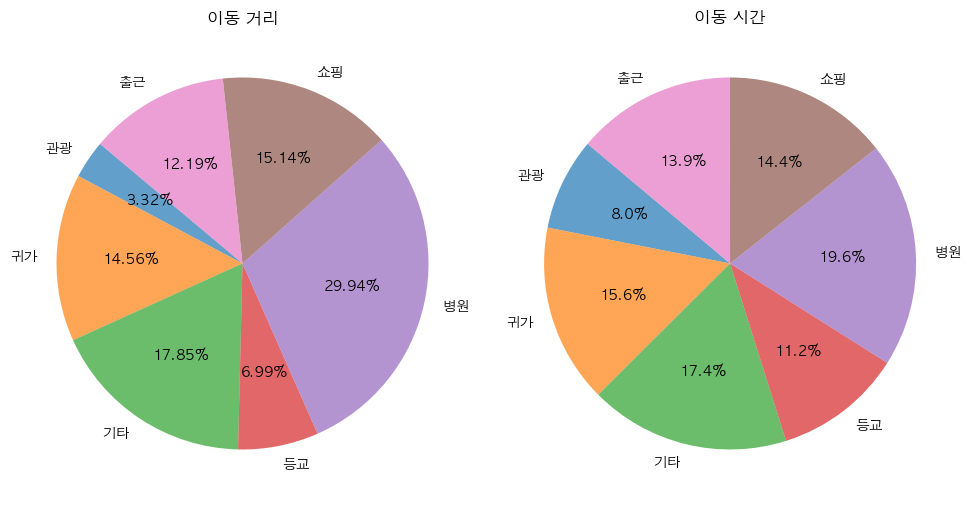

In [72]:
# 시각화 plot 크기 지정
plt.figure(figsize=(10, 5))

# 첫 번째 subplot - 이동 거리
'''
pie의 인자 설명
grouped["move_dist] - 파이 조각의 크기 값들 (거리 비율 등의 수치값)
labes=["move_purpose"] - 각 조각에 붙일 라벨
autopct = "%1.1f%%" - 퍼센트 표시형식 (1.1f : 소수점 한자리까지)
startangle = 140 - 그래프의 시작각도 기본은 0도 (오른쪽에서 시작)
'''
plt.subplot(1, 2, 1)
plt.pie(grouped["move_dist"], labels=grouped["move_purpose"], autopct='%1.2f%%', startangle=140, wedgeprops={'alpha': 0.7})
plt.title("이동 거리")

# 두 번째 subplot - 이동 시간
plt.subplot(1, 2, 2)
plt.pie(grouped["move_time"], labels=grouped["move_purpose"], autopct='%1.1f%%', startangle=140, wedgeprops={'alpha': 0.7})
plt.title("이동 시간")

plt.tight_layout()
plt.show()

이동 목적 카테고리 중에서 평균 이동 거리와 시간이 가장 긴 카테고리는 병원이었습니다.   
한편, 사람들은 평균적으로 출근에 걸리는 거리보다 더 멀리 쇼핑을 하러 갔네요!

----

### 3.3. 서울과 그 외 지역의 생활 이동 인구 비교

>🛣 "서울 안에서 이동하는 사람이 더 많을까, 아니면 서울 바깥으로 나가거나 안으로 들어오는 사람이 더 많을까?"

서울 안에서 이동하는 인구, 그리고 서울에서 출발하거나 서울로 도착하는 인구 수를 비교해보고, 서울 유입/유출 인구를 시각회해봅니다.

먼저, 서울 안에서 이동하는 경우만 필터링하여 이동 인구 수와 평균 거리, 시간을 계산해봅시다. 

In [73]:
# 서울 안에서 이동하는 경우만 필터링
filtered_df = mobility_df[(mobility_df['o_SIDO'] == '서울특별시') & (mobility_df['d_SIDO'] == '서울특별시')]

print(f"이동 인구 수: {filtered_df['cnt'].sum()}")
print(f"평균 이동 거리: {filtered_df['move_dist'].sum()}")
print(f"평균 이동 시간: {filtered_df['move_time'].sum()}")

이동 인구 수: 18027800.439999994
평균 이동 거리: 19183599584.89756
평균 이동 시간: 150444164.3989966


이번에는 서울에서 출발하거나 서울로 도착하는 경우를 살펴봅시다.

In [74]:
# 서울에서 출발하여 다른 지역으로 이동하는 경우만 필터링
filtered_df = mobility_df[(mobility_df['o_SIDO'] == '서울특별시') & (mobility_df['d_SIDO'] != '서울특별시')]

print(f"이동 인구 수: {filtered_df['cnt'].sum()}")
print(f"평균 이동 거리: {filtered_df['move_dist'].sum()}")
print(f"평균 이동 시간: {filtered_df['move_time'].sum()}")

이동 인구 수: 3710258.7199999997
평균 이동 거리: 33730119279.92927
평균 이동 시간: 82275220.15930058


In [75]:
# 다른 지역으로 출발하여 서울로 이동하는 경우만 필터링
filtered_df = mobility_df[(mobility_df['o_SIDO'] != '서울특별시') & (mobility_df['d_SIDO'] == '서울특별시')]

print(f"이동 인구 수: {filtered_df['cnt'].sum()}")
print(f"평균 이동 거리: {filtered_df['move_dist'].sum()}")
print(f"평균 이동 시간: {filtered_df['move_time'].sum()}")

이동 인구 수: 3767971.19
평균 이동 거리: 33445077618.841248
평균 이동 시간: 85312172.39358988


비교해보면 서울 안에서 이동하는 인구 수가 훨씬 많은 것을 확인할 수 있습니다.

이번에는 이동 목적이 출근인 경우에 서울의 유입/유출 인구를 시각화해볼까요?

    o_SIDO o_SGG       o_ADMI d_SIDO d_SGG       d_ADMI st_time_str  \
28   서울특별시   종로구          삼청동  서울특별시   종로구          가회동       00:00   
56   서울특별시   종로구          교남동  서울특별시   종로구          교남동       00:00   
74   서울특별시   종로구  종로1.2.3.4가동  서울특별시   종로구  종로1.2.3.4가동       00:00   
134  서울특별시   종로구          혜화동  서울특별시   종로구          이화동       00:00   
145  서울특별시   종로구          혜화동  서울특별시   종로구          혜화동       00:00   

    fns_time_str in_forn_div_nm forn_citiz_nm move_purpose  move_dist  \
28         00:00            내국인            한국           출근      180.3   
56         00:00            내국인            한국           출근       50.0   
74         00:00            내국인          ㆍ값없음           출근      255.0   
134        00:00            내국인            한국           출근      700.0   
145        00:00            내국인          ㆍ값없음           출근      141.4   

     move_time   cnt st_time_hr fns_time_hr  
28    2.013333  3.00      00:00       00:00  
56    3.678333  2.30      00:00       00:0

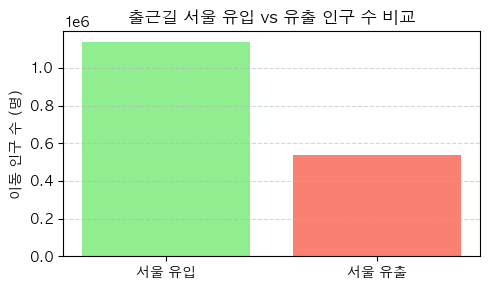

In [78]:
# 이동 목적이 출근인 경우만 필터링
filtered_df = mobility_df[(mobility_df['move_purpose'] == '출근')]
print(filtered_df.head())

# 서울 유입 인구만 필터링
filtered_in_df = filtered_df[(filtered_df['o_SIDO'] != '서울특별시') & (filtered_df['d_SIDO'] == '서울특별시')]

# 서울 유출 인구만 필터링
filtered_out_df = filtered_df[(filtered_df['o_SIDO'] == '서울특별시') & (filtered_df['d_SIDO'] != '서울특별시')]

plt.figure(figsize=(5, 3))
plt.bar(['서울 유입', '서울 유출'], [filtered_in_df['cnt'].sum(), filtered_out_df['cnt'].sum()], color=['lightgreen', 'salmon'])
plt.title("출근길 서울 유입 vs 유출 인구 수 비교")
plt.ylabel("이동 인구 수 (명)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

서울 외부에서 서울로 출근하는 경우가 그 반대의 경우보다 훨씬 많은 것을 알 수 있습니다.

---

### 3.4. 서울 자치구 간 이동 흐름 시각화

>🚗 "우리집 주변은 교통이 많이 복잡하진 않으면 좋겠어. 어느 지역이 조금 더 조용할까?"   

서울 자치구 간 이동 흐름을 분석하여 지도 위에 나타내봅니다.

먼저 서울 내 이동인 경우만 필터링합니다.

In [79]:
# 서울 내 이동인 경우만 필터링
filtered_df = mobility_df[(mobility_df['o_SIDO'] == '서울특별시') & (mobility_df['d_SIDO'] == '서울특별시')]

# 출발 및 도착 구별로 그룹화하여 이동 인구 수 합 계산
grouped = filtered_df.groupby(["o_SGG", "d_SGG"], as_index=False)["cnt"].sum()
grouped

,o_SGG,d_SGG,cnt
0,강남구,강남구,905600.96
1,강남구,강동구,39398.78
2,강남구,강북구,8506.26
3,강남구,강서구,21515.66
4,강남구,관악구,46268.17
...,...,...,...
620,중랑구,용산구,4262.50
621,중랑구,은평구,1297.43
622,중랑구,종로구,9177.63
623,중랑구,중구,10140.39


현재는 `강남구 → 강동구`와 `강동구 → 강남구`처럼 출발/도착 자치구가 구분되어 그룹화됐네요.   
그런데 지도에는 `강남구 ↔ 강동구`와 같이 양방향으로 이동 인구를 합쳐서 표시하고 싶습니다.    
이를 위해 양방향 이동 인구를 합쳐서 새롭게 그룹화해볼까요?

In [80]:
# 양방향으로 그룹화하고 이동량 합치기 
grouped['pair'] = grouped.apply(lambda row: tuple(sorted([row['o_SGG'], row['d_SGG']])), axis=1)
merged = grouped.groupby('pair', as_index=False)['cnt'].sum()
merged

,pair,cnt
0,"(강남구, 강남구)",905600.96
1,"(강남구, 강동구)",80821.11
2,"(강남구, 강북구)",17531.77
3,"(강남구, 강서구)",43441.86
4,"(강남구, 관악구)",94916.36
...,...,...
320,"(종로구, 중구)",130354.38
321,"(종로구, 중랑구)",18265.92
322,"(중구, 중구)",290894.67
323,"(중구, 중랑구)",19840.61


위와 같이 양방향 이동 인구 수가 합쳐졌습니다.   
이제 이 데이터를 지도 위에 직접 표시해볼까요?   
자치구들을 서로 연결하는 선을 그리며, 양방향 이동 인구 수가 많을 수록 선을 더 굵게 표시하면 좋을 것 같네요.    
지도 시각화에는 `folium`이라는 라이브러리를 사용합니다.

>📌 `folium`은 지리 정보를 시각화할 수 있는 지도를 생성하는 라이브러리입니다. `PolyLine()`은 지도 위에 두 지점 이상의 좌표를 연결하는 선을 그려주는 도구로, 경로 시각화나 이동 흐름 표현에 사용됩니다.

우선 지도 위에서 자치구별 기준점이 될 위/경도 데이터가 필요합니다.    
다음과 같이 딕셔너리 형태로 자치구별 위/경도 데이터를 저장합니다.

In [81]:
# 자치구별 위/경도 데이터
geo_dict = {
    '강남구': [37.5172363, 127.0473248],
    '강동구': [37.5301251, 127.1237629],
    '강북구': [37.6396103, 127.025657],
    '강서구': [37.5509375, 126.8495382],
    '관악구': [37.4784063, 126.9516134],
    '광진구': [37.5384841, 127.0822931],
    '구로구': [37.4954856, 126.8874961],
    '금천구': [37.4600969, 126.9001546],
    '노원구': [37.6541917, 127.0567939],
    '도봉구': [37.6687686, 127.0471634],
    '동대문구': [37.5743681, 127.0396171],
    '동작구': [37.512409, 126.939252],
    '마포구': [37.5663244, 126.9014014],
    '서대문구': [37.5791158, 126.9367789],
    '서초구': [37.4837125, 127.0324113],
    '성동구': [37.5633415, 127.0360835],
    '성북구': [37.5894003, 127.0167035],
    '송파구': [37.5145431, 127.1065971],
    '양천구': [37.5169836, 126.8663985],
    '영등포구': [37.5263718, 126.8960577],
    '용산구': [37.5323669, 126.9906798],
    '은평구': [37.6176127, 126.9227004],
    '종로구': [37.5729503, 126.9793579],
    '중구': [37.5638437, 126.997602],
    '중랑구': [37.6063243, 127.0929866]
}

그리고 `folium`을 통해 지도와 선을 시각화합니다.

In [82]:
# 지도 생성
m = folium.Map(location=[37.5665, 126.9780], zoom_start=11)

# 양방향 이동 인구 수 데이터에 기반하여 선 그리기
for _, row in merged.iterrows():
    loc1, loc2 = row['pair']
    start = geo_dict.get(loc1)
    end = geo_dict.get(loc2)
    if start and end:
        weight = (row['cnt'] / merged['cnt'].max()) * 25
        folium.PolyLine(
            locations=[start, end],
            weight=weight,
            color='blue',
            opacity=0.5,
            tooltip=f"{loc1} ↔ {loc2} : {int(row['cnt'])}명"
        ).add_to(m)

m

마우스를 선 위에 올리면 `강남구 ↔ 서초구 : 367760명`과 같은 설명을 볼 수 있습니다.   
놀랍게도 강남구 안에서만 이동하는 인구가 눈에 띄게 많네요!

위의 지도는 이동 목적을 구분하지 않은 전체 이동을 시각화한 것인데요.    
그렇다면 이번에는 특정 목적의 이동만 필터링하여 지도에 표시해볼까요?

In [83]:
# 서울 내 쇼핑 목적의 이동만 필터링
filtered_df = mobility_df[(mobility_df['o_SIDO'] == '서울특별시') & (mobility_df['d_SIDO'] == '서울특별시') & (mobility_df['move_purpose'] == '쇼핑')]
grouped = filtered_df.groupby(["o_SGG", "d_SGG"], as_index=False)["cnt"].sum()

# 양방향으로 그룹화하고 이동량 합치기 
grouped['pair'] = grouped.apply(lambda row: tuple(sorted([row['o_SGG'], row['d_SGG']])), axis=1)
merged = grouped.groupby('pair', as_index=False)['cnt'].sum()
merged

# 지도 생성
m = folium.Map(location=[37.5665, 126.9780], zoom_start=11)

# 양방향 이동 인구 수 데이터에 기반하여 선 그리기
for _, row in grouped.iterrows():
    start = geo_dict.get(row['o_SGG'])
    end = geo_dict.get(row['d_SGG'])
    if start and end:
        weight = (row['cnt'] / grouped['cnt'].max()) * 25
        folium.PolyLine(
            locations=[start, end],
            weight =weight,
            color='purple',
            opacity=0.9,
            tooltip=f"{row['o_SGG']} → {row['d_SGG']} : {int(row['cnt'])}명"
        ).add_to(m)

m

앞서 살펴본 지도와는 다른 양상을 보여줍니다.    
특히 송파구 내에서의 쇼핑 이동 인구가 굉장히 많은 것을 확인할 수 있습니다.

---

### <span style="font-size:24px">[Quiz 1]</span>

❓가장 많은 인구가 방문한(도착한) 서울 자치구는 어디일까요?

- 조건:
    - 도착 지역을 기준으로 그룹화하였을 때 이동 인구 수의 합이 가장 많은 서울 자치구(`d_SGG`)
    - 서울 내외부에서 출발하는 경우 전부 포함 (`o_SIDO`, `o_SGG`는 어디든 상관 없음)
    - 같은 자치구에서 출발하여 도착하는 것도 포함 (예를 들어 관악구에서 출발(`o_SGG == '관악구'`)하여 관악구로 도착(`d_SGG == '관악구'`)하는 경우도 관악구를 방문한 인구에 포함)
- 답안 형식:
    - `quiz_1` 변수에 답안을 `string` 형식으로 저장 (예: "관악구")

In [90]:
filtered_df = mobility_df[mobility_df['d_SIDO'] == '서울특별시']
grouped = filtered_df.groupby(['d_SGG'], as_index=False)["cnt"].sum()
grouped = grouped.sort_values('cnt', ascending=False)
grouped.head()

,d_SGG,cnt
0,강남구,2258272.23
17,송파구,1541334.61
14,서초구,1416363.74
19,영등포구,1153186.20
3,강서구,1144083.98


In [91]:
# 힌트:
# 먼저 'd_SIDO' == '서울특별시'인 경우를 필터링합니다.
# 서울 외부 수도권에서 출발하는 경우와 같은 자치구에서 출발하여 도착하는 경우도 전부 포함하므로, 간단히 'd_SGG'를 기준으로 그룹화하여 이동 인구 수의 합을 구하면 됩니다.

filtered_df = mobility_df[(mobility_df['d_SIDO'] == '서울특별시')]
grouped = filtered_df.groupby(["d_SGG"], as_index=False)["cnt"].sum()
top_10 = grouped.sort_values('cnt', ascending=False).head(10)
print(top_10)

   d_SGG         cnt
0    강남구  2258272.23
17   송파구  1541334.61
14   서초구  1416363.74
19  영등포구  1153186.20
3    강서구  1144083.98
12   마포구  1041420.76
23    중구   985362.52
1    강동구   939391.96
22   종로구   822553.48
8    노원구   810488.85


In [92]:
# 답안 (예: quiz_1 = '관악구')
quiz_1 = "강남구"

---

### 3.5. 내국인과 외국인의 이동 패턴 비교

>🏙 "오, 여기는 우리 지역보다 외국인이 정말 많이 있네!"

내국인과 외국인을 기준으로 나누어 지역별 이동 인구 수를 비교해봅니다. 

우선 출발/도착 지역과 내/외국인 기준으로 그룹화하여 이동 인구 수의 합을 구합니다.

In [93]:
# 출발/도착 지역과 내/외국인 기준 이동 인구 수의 합
grouped = mobility_df.groupby(["o_SIDO", "o_SGG", "d_SIDO","d_SGG", "in_forn_div_nm"], as_index=False)["cnt"].sum()
grouped

,o_SIDO,o_SGG,d_SIDO,d_SGG,in_forn_div_nm,cnt
0,강원특별자치도,강릉시,경기도,가평군,내국인,364.79
1,강원특별자치도,강릉시,경기도,가평군,단기외국인,105.00
2,강원특별자치도,강릉시,경기도,고양시 덕양구,내국인,168.86
3,강원특별자치도,강릉시,경기도,고양시 덕양구,단기외국인,91.00
4,강원특별자치도,강릉시,경기도,고양시 일산동구,내국인,132.92
...,...,...,...,...,...,...
58935,충청북도,충주시,인천광역시,연수구,단기외국인,42.00
58936,충청북도,충주시,인천광역시,연수구,장기외국인,7.00
58937,충청북도,충주시,인천광역시,중구,내국인,287.70
58938,충청북도,충주시,인천광역시,중구,단기외국인,56.00


여기서 내국인인 경우만 필터링하여 별도의 데이터프레임으로 저장합니다.

In [94]:
# 내국인인 경우만 필터링하여 저장
domestic_df = grouped[grouped['in_forn_div_nm'] == '내국인'].copy()
domestic_df.drop(columns=['in_forn_div_nm'], inplace=True)
domestic_df

,o_SIDO,o_SGG,d_SIDO,d_SGG,cnt
0,강원특별자치도,강릉시,경기도,가평군,364.79
2,강원특별자치도,강릉시,경기도,고양시 덕양구,168.86
4,강원특별자치도,강릉시,경기도,고양시 일산동구,132.92
6,강원특별자치도,강릉시,경기도,고양시 일산서구,83.37
8,강원특별자치도,강릉시,경기도,과천시,13.18
...,...,...,...,...,...
58926,충청북도,충주시,인천광역시,미추홀구,144.88
58929,충청북도,충주시,인천광역시,부평구,80.80
58932,충청북도,충주시,인천광역시,서구,152.99
58934,충청북도,충주시,인천광역시,연수구,138.00


이번엔 외국인인 경우만 필터링하여 별도의 데이터프레임으로 저장합니다.

In [95]:
# 내국인이 아닌 경우만 필터링하여 저장
foreign_df = grouped[grouped['in_forn_div_nm'] != '내국인']
foreign_df

,o_SIDO,o_SGG,d_SIDO,d_SGG,in_forn_div_nm,cnt
1,강원특별자치도,강릉시,경기도,가평군,단기외국인,105.0
3,강원특별자치도,강릉시,경기도,고양시 덕양구,단기외국인,91.0
5,강원특별자치도,강릉시,경기도,고양시 일산동구,단기외국인,28.0
7,강원특별자치도,강릉시,경기도,고양시 일산서구,단기외국인,24.5
9,강원특별자치도,강릉시,경기도,과천시,단기외국인,7.0
...,...,...,...,...,...,...
58933,충청북도,충주시,인천광역시,서구,단기외국인,80.5
58935,충청북도,충주시,인천광역시,연수구,단기외국인,42.0
58936,충청북도,충주시,인천광역시,연수구,장기외국인,7.0
58938,충청북도,충주시,인천광역시,중구,단기외국인,56.0


`in_forn_div_nm` 컬럼을 살펴보니 외국인이 `단기외국인`과 `장기외국인` 등으로 구분되어 있습니다.   
그래서 맨 아래 두 행을 보면, `충청북도 충주시`에서 출발하여 `인천광역시 중구`에 도착하는 경우가 `단기외국인`/`장기외국인`으로 구분되어있네요.    
같은 출발/도착 지역인 경우에 이들을 합하는 과정이 필요합니다.

In [96]:
# 같은 출발/도착 지역인 경우 값을 다시 합하기
foreign_df = foreign_df.groupby(["o_SIDO", "o_SGG", "d_SIDO","d_SGG"], as_index=False)["cnt"].sum()
foreign_df

,o_SIDO,o_SGG,d_SIDO,d_SGG,cnt
0,강원특별자치도,강릉시,경기도,가평군,105.0
1,강원특별자치도,강릉시,경기도,고양시 덕양구,91.0
2,강원특별자치도,강릉시,경기도,고양시 일산동구,28.0
3,강원특별자치도,강릉시,경기도,고양시 일산서구,24.5
4,강원특별자치도,강릉시,경기도,과천시,7.0
...,...,...,...,...,...
21633,충청북도,충주시,인천광역시,미추홀구,38.5
21634,충청북도,충주시,인천광역시,부평구,45.5
21635,충청북도,충주시,인천광역시,서구,80.5
21636,충청북도,충주시,인천광역시,연수구,49.0


이제 `충청북도 충주시`에서 출발하여 `인천광역시 중구`에 도착하는 경우가 하나로 합쳐졌습니다.  

내국인과 외국인으로 구분된 각 데이터에서 이동 인구 수 상위 10개의 데이터를 출력해볼까요?

In [97]:
# 내국인 기준 이동 인구 수 상위 10개 현황
top10_domestic = domestic_df.sort_values('cnt', ascending=False).head(10)
top10_domestic

,o_SIDO,o_SGG,d_SIDO,d_SGG,cnt
23706,경기도,화성시,경기도,화성시,1077826.59
22140,경기도,평택시,경기도,평택시,779372.17
33047,서울특별시,강남구,서울특별시,강남구,717426.96
7559,경기도,남양주시,경기도,남양주시,664235.19
41654,서울특별시,송파구,서울특별시,송파구,650943.95
48868,인천광역시,서구,인천광역시,서구,640874.52
9738,경기도,성남시 분당구,경기도,성남시 분당구,557257.64
21652,경기도,파주시,경기도,파주시,554910.58
7041,경기도,김포시,경기도,김포시,537714.86
34545,서울특별시,강서구,서울특별시,강서구,478223.18


In [98]:
# 외국인 기준 이동 인구 수 상위 10개 현황
top10_foreign = foreign_df.sort_values('cnt', ascending=False).head(10)
top10_foreign

,o_SIDO,o_SGG,d_SIDO,d_SGG,cnt
8873,경기도,화성시,경기도,화성시,364738.50
8288,경기도,평택시,경기도,평택시,305735.00
12262,서울특별시,강남구,서울특별시,강남구,188174.00
2894,경기도,남양주시,경기도,남양주시,163754.50
8113,경기도,파주시,경기도,파주시,157711.54
17870,인천광역시,서구,인천광역시,서구,150874.50
2699,경기도,김포시,경기도,김포시,145640.46
4960,경기도,시흥시,경기도,시흥시,140570.50
18066,인천광역시,연수구,인천광역시,연수구,137868.50
3674,경기도,성남시 분당구,경기도,성남시 분당구,126416.50


내국인과 외국인 기준으로 모두 경기도 화성시 안에서 이동 인구 수가 가장 많았네요.    
한편 내국인의 송파구 내 이동이 5위인 것에 비해, 외국인의 경우 서울 송파구로의 이동은 잘 일어나지 않는 것으로 보입니다. 


---

### 3.6. 출근 지역별 평균 이동 거리/시간 분석

>👞 "우리나라에서 출근 거리가 가장 긴 사람들의 출근 경로는 어떻게 될까?"   

출근 지역별 평균 이동 거리와 시간을 살펴보고, 이동 거리와 시간 간의 상관관계 및 이상치를 분석해봅니다.

먼저 이동 목적이 출근인 경우만 필터링하고, 출발/도착 지역으로 그룹화하하여 이동 거리와 이동 시간의 평균을 구합니다.

In [99]:
# 이동 목적이 출근인 경우만 필터링
filtered_df = mobility_df[(mobility_df['move_purpose'] == '출근')]

# 출발/도착 지역으로 그룹화하여 이동 거리와 이동 시간의 평균 계산  
grouped = filtered_df.groupby(["o_SIDO", "o_SGG", "d_SIDO", "d_SGG"], as_index=False)[["move_dist", "move_time"]].mean()

이제 이동 거리와 이동 시간 기준으로 상위 10개의 현황을 출력해봅시다.

In [100]:
# 이동 거리가 가장 긴 상위 10개 현황
top10_dist = grouped.sort_values('move_dist', ascending=False).head(10)
top10_dist

,o_SIDO,o_SGG,d_SIDO,d_SGG,move_dist,move_time
13794,제주특별자치도,제주시,경기도,포천시,502949.100000,331.618333
959,경기도,고양시 덕양구,제주특별자치도,서귀포시,487216.950000,253.503333
13762,제주특별자치도,서귀포시,서울특별시,성북구,485116.600000,294.691667
13749,제주특별자치도,서귀포시,경기도,고양시 덕양구,482560.300000,194.860000
13792,제주특별자치도,제주시,경기도,파주시,480618.900000,201.495000
13766,제주특별자치도,서귀포시,서울특별시,종로구,480029.800000,217.091667
10169,서울특별시,마포구,제주특별자치도,서귀포시,479169.400000,228.716667
13761,제주특별자치도,서귀포시,서울특별시,마포구,479053.400000,194.145000
12004,서울특별시,중랑구,제주특별자치도,제주시,478567.300000,307.633333
13758,제주특별자치도,서귀포시,서울특별시,강서구,477282.066667,203.547778


In [101]:
# 이동 시간이 가장 긴 상위 10개 현황
top10_time = grouped.sort_values('move_time', ascending=False).head(10)
top10_time

,o_SIDO,o_SGG,d_SIDO,d_SGG,move_dist,move_time
8363,서울특별시,강남구,부산광역시,강서구,309884.00,964.651667
5349,경기도,용인시 처인구,강원특별자치도,화천군,138231.00,928.228333
6874,경상북도,경주시,경기도,오산시,240342.00,691.001667
7778,대전광역시,서구,경기도,고양시 일산서구,159343.30,663.905000
8241,부산광역시,해운대구,경기도,용인시 처인구,273360.10,658.393333
11706,서울특별시,종로구,제주특별자치도,서귀포시,475826.55,620.417500
6744,경상남도,창원시 마산회원구,경기도,수원시 권선구,265627.70,613.698333
8236,부산광역시,해운대구,경기도,수원시 장안구,307736.70,604.770000
13368,전라남도,영암군,경기도,남양주시,304192.90,598.520000
6622,경상남도,거제시,서울특별시,송파구,321306.90,593.158333


이동 거리가 가장 긴 경우는 무려 제주도에서 경기도 포천시까지의 이동이었네요!   
그리고 이동 시간이 가장 긴 경우는 서울 강남구에서 부산 강서구까지의 이동이었습니다.    

그런데 여기서 조금 이상한 점을 발견하셨나요?    
이동 거리가 길면 당연히 이동 시간도 길 줄 알았는데, 위 데이터를 보니 꼭 그렇지만은 않은 것 같습니다.    
이동 시간과 이동 거리의 상관관계가 궁금해지네요.    
다음과 같이 상관관계를 구해봅시다.

>📌 `pandas.DataFrame`의 `corr()`는 두 변수 간의 상관계수를 계산하여, 서로 얼마나 선형적으로 관련이 있는지를 수치로 보여줍니다.

In [102]:
# 이동 시간과 이동 거리의 상관관계
correlation = filtered_df['move_dist'].corr(filtered_df['move_time'])
print("상관계수 (Pearson):", correlation)

상관계수 (Pearson): 0.4710764381977674


상관계수가 0.47 정도로 '다소 높은 상관관계'를 지니고는 있지만, 예상했던 것보다는 조금 낮습니다. 

이번에는 산점도를 통해 이동 거리와 이동 시간의 분포를 시각화해봅시다.   
>📌 `scatter()`는 두 변수 간의 관계나 분포를 시각화하기 위해 점들을 사용해 산점도를 그립니다.

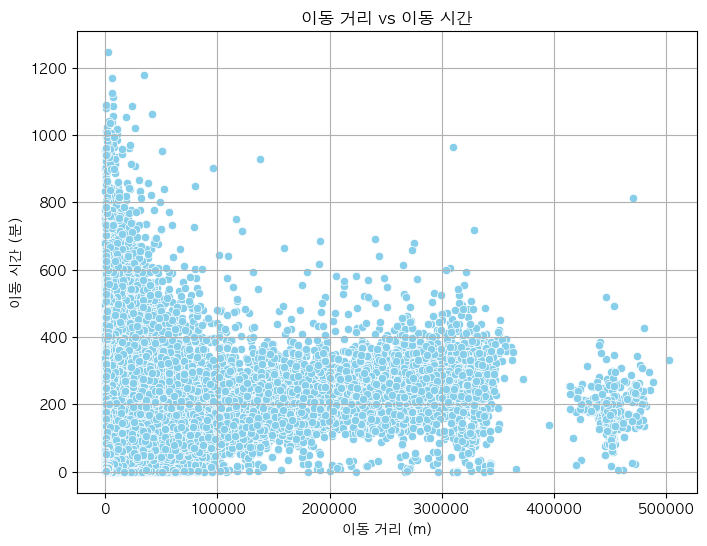

In [103]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=filtered_df, x='move_dist', y='move_time', color='skyblue')
plt.title('이동 거리 vs 이동 시간')
plt.xlabel('이동 거리 (m)')
plt.ylabel('이동 시간 (분)')
plt.grid(True)
plt.show()

산점도를 살펴보니 이동 거리가 0에 가까운데 이동 시간은 엄청 길거나, 이동 시간이 0에 가까운데 이동 거리는 엄청 긴, 다시 말해 '이상치'들이 많은 것 같습니다.    
이상치를 분석하기 위해 박스 플롯을 그려봅시다.

>📌 `boxplot()`은 데이터의 중앙값, 사분위수, 이상치 등 분포의 특징을 시각화하는 박스 플롯을 생성합니다.


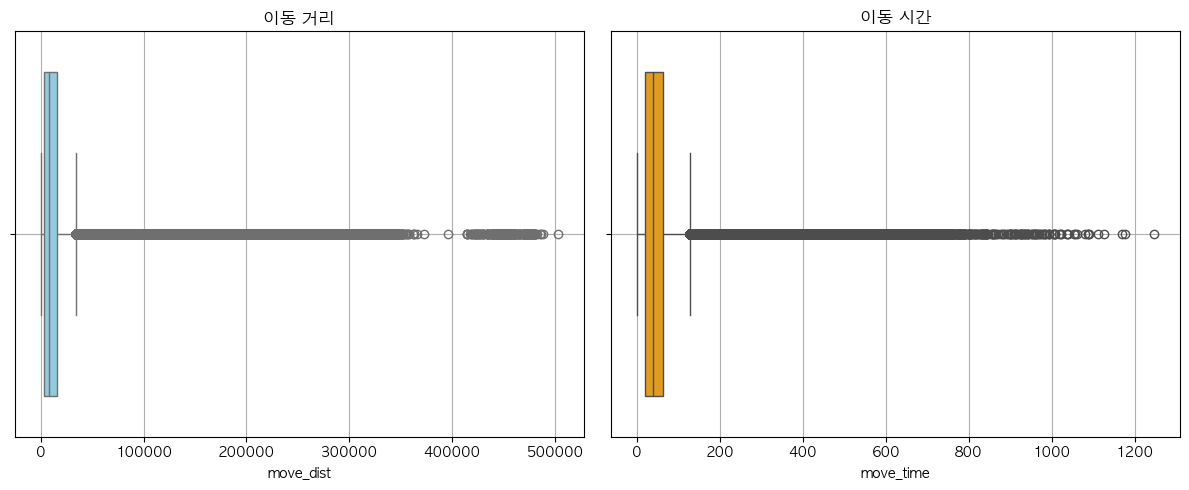

In [104]:
plt.figure(figsize=(12, 5)) 

# 첫 번째 subplot: 이동 거리 boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x=filtered_df['move_dist'], color='skyblue')
plt.title('이동 거리')
plt.grid(True)

# 두 번째 subplot: 이동 시간 boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=filtered_df['move_time'], color='orange')
plt.title('이동 시간')
plt.grid(True)

plt.tight_layout()
plt.show()

박스 플롯에서 박스 밖의 이상치(점)들이 굉장히 많은 것을 볼 수 있습니다.     
이번에는 각 이상치의 개수를 세어볼까요?    
이상치의 기준은 다음과 같습니다.
- IQR = Q3 - Q1
- 하한 = Q1 - 1.5 * IQR
- 상한 = Q3 + 1.5 * IQR

In [105]:
# IQR과 상/하한 설정
Q1_dist = filtered_df['move_dist'].quantile(0.25)
Q3_dist = filtered_df['move_dist'].quantile(0.75)
IQR_dist = Q3_dist - Q1_dist

lower_bound_dist = Q1_dist - 1.5 * IQR_dist
upper_bound_dist = Q3_dist + 1.5 * IQR_dist

outliers_dist = filtered_df[
    (filtered_df['move_dist'] < lower_bound_dist) | 
    (filtered_df['move_dist'] > upper_bound_dist)
]
num_outliers_dist = len(outliers_dist)
mean_dist = filtered_df['move_dist'].mean()

# 이동 시간 (move_time) 이상치 계산
Q1_time = filtered_df['move_time'].quantile(0.25)
Q3_time = filtered_df['move_time'].quantile(0.75)
IQR_time = Q3_time - Q1_time

lower_bound_time = Q1_time - 1.5 * IQR_time
upper_bound_time = Q3_time + 1.5 * IQR_time

outliers_time = filtered_df[
    (filtered_df['move_time'] < lower_bound_time) | 
    (filtered_df['move_time'] > upper_bound_time)
]
num_outliers_time = len(outliers_time)
mean_time = filtered_df['move_time'].mean()

# 결과 출력
print(f"전체 데이터 수: {len(filtered_df)}\n")
print(f"이동 거리 평균: {mean_dist:,.2f}")
print(f"이동 거리 하한: {lower_bound_dist:,.2f}")
print(f"이동 거리 상한: {upper_bound_dist:,.2f}")
print(f"이동 거리 이상치 개수: {num_outliers_dist}\n")

print(f"이동 시간 평균: {mean_time:,.2f}")
print(f"이동 시간 하한: {lower_bound_time:,.2f}")
print(f"이동 시간 상한: {upper_bound_time:,.2f}")
print(f"이동 시간 이상치 개수: {num_outliers_time}")

전체 데이터 수: 2252091

이동 거리 평균: 12,654.07
이동 거리 하한: -15,790.15
이동 거리 상한: 34,802.25
이동 거리 이상치 개수: 113093

이동 시간 평균: 47.90
이동 시간 하한: -45.23
이동 시간 상한: 128.47
이동 시간 이상치 개수: 85275


이동 거리와 시간 각각의 이상치 개수는 113093, 85275개로 전체 데이터 수의 약 5% 내외인 것을 확인할 수 있습니다.

---

### <span style="font-size:24px">[Quiz 2]</span>

❓출근에 걸리는 평균 시간이 가장 긴 지역은 어디일까요?

- 조건:
    - 이동 목적이 출근인 경우만 출발 지역을 기준으로 그룹화하였을 때 이동 시간의 평균이 가장 큰 지역(`o_SIDO`, `o_SGG`)
    - 출발 지역을 기준으로 하며, 도착 지역은 고려하지 않음 (`d_SIDO`, `d_SGG`는 어디든 상관 없음)
- 답안 형식:
    - `quiz_2` 변수에 답안을 `dict`에 `string` 형식으로 저장

In [116]:
filtered_df = mobility_df[mobility_df["move_purpose"] == '출근']
filtered_df.head()
grouped = filtered_df.groupby(['o_SIDO','o_SGG'], as_index=False)[['move_time']].mean()
grouped = grouped.sort_values('move_time', ascending=False)
grouped.head(10)

,o_SIDO,o_SGG,move_time
66,경상남도,남해군,362.790556
195,전라남도,완도군,355.740000
194,전라남도,영암군,337.345208
180,전라남도,강진군,333.997500
181,전라남도,고흥군,333.088889
62,경상남도,거제시,325.051042
77,경상남도,창원시 진해구,321.028922
79,경상남도,하동군,320.463333
199,전라남도,해남군,317.698333
197,전라남도,진도군,312.214444


In [ ]:
# 힌트:
# 먼저 'move_purpose' == '출근'인 경우를 필터링합니다.
# 도착 지역은 고려하지 않으므로, 간단히 'o_SIDO'와 'o_SGG'를 기준으로 그룹화하여 이동 시간의 평균을 구하면 됩니다.
filtered_df = mobility_df[(mobility_df["move_purpose"] == '출근')]
grouped = filtered_df.groupby(["o_SIDO", "o_SGG"], as_index=False)[["move_time"]].mean()
top10_time = grouped.sort_values('move_time', ascending=False).head(10)
print(top10_time)

In [117]:
# 답안 (예: quiz_2 = {
#    "o_SIDO": "서울특별시",
#    "o_SGG": "관악구"
# })
quiz_2 = {
    "o_SIDO": "경상남도",
    "o_SGG": "남해군"
}

---

### 3.7. 이동 목적별 평일 vs 주말 이동 인구 수 비교

>🛒 "모처럼 휴가내고 쇼핑을 왔는데 사람이 꽤 많네! 평일 쇼핑 인구는 주말에 비해 얼마나 될까?"

평일과 주말의 이동 목적별 인구 수를 비교해봅시다.

지금까지 분석한 `mobility_df`는 평일(월요일) 데이터였습니다.    
이번에는 주말 데이터를 불러와볼까요?    
용량이 크기 때문에 다소 시간이 걸릴 수 있습니다. (약 30초)

In [118]:
# 주말 생활이동 데이터 (2025년 2월 22일 토요일)
mobility_df_weekend = pd.read_csv("data/mobility_df_weekend.csv", encoding='utf-8')

이제 주말 데이터를 이동 목적별로 그룹화 하여 이동 인구 수의 합을 구해봅시다.

In [119]:
# 주말 이동 목적별 인구 수
grouped_weekend = mobility_df_weekend.groupby(["move_purpose"], as_index=False)["cnt"].sum()
grouped_weekend

,move_purpose,cnt
0,관광,33512.23
1,귀가,19420613.64
2,기타,31062647.28
3,등교,397673.43
4,병원,42010.47
5,쇼핑,488174.05
6,출근,3789211.35


평일 데이터도 마찬가지로 계산해봅시다.

In [120]:
# 평일 이동 목적별 인구 수
grouped_week = mobility_df.groupby(["move_purpose"], as_index=False)["cnt"].sum()
grouped_week

,move_purpose,cnt
0,관광,27765.88
1,귀가,21040544.51
2,기타,25582252.01
3,등교,795242.51
4,병원,123484.65
5,쇼핑,204638.40
6,출근,10000690.89


평일과 주말의 차이를 더 직관적으로 확인하기 위해 시각화를 해볼까요?    
각 목적마다 평일/주말의 이동 인구 수가 나란히 배치되어 표시된다면 한 눈에 비교하기 좋을 것 같습니다.

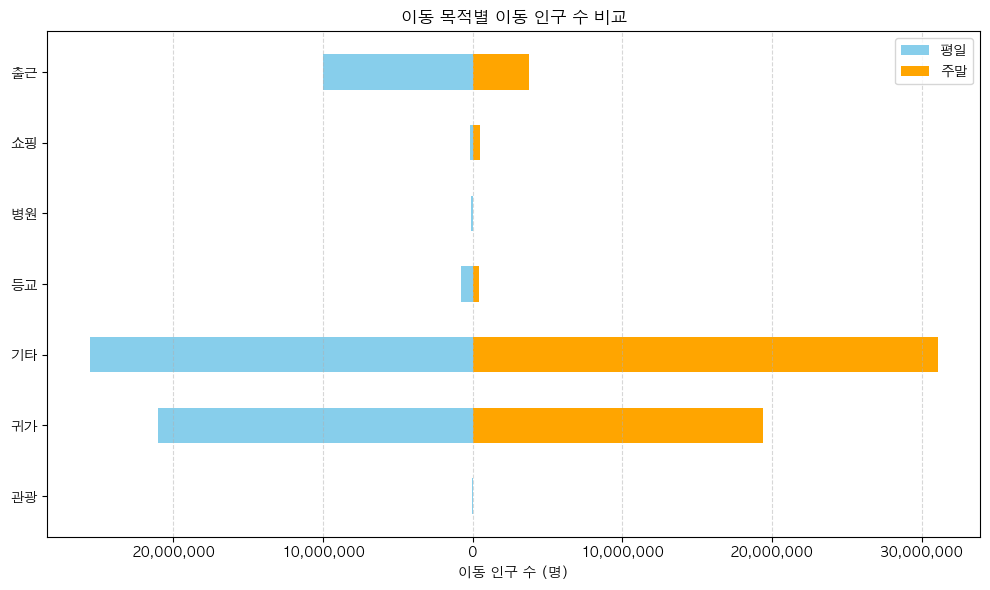

In [121]:
# 공통 y값 정렬
categories = grouped_week['move_purpose']
y_pos = np.arange(len(categories))
bar_height = 0.5

plt.figure(figsize=(10, 6))

plt.barh(y=y_pos, width=-grouped_week['cnt'], height=bar_height, label='평일', color='skyblue')
plt.barh(y=y_pos, width=grouped_weekend['cnt'], height=bar_height, label='주말', color='orange')

plt.yticks(ticks=y_pos, labels=categories)
plt.xlabel('이동 인구 수 (명)')
plt.title('이동 목적별 이동 인구 수 비교')
plt.legend()
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{abs(int(x)):,}'))
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

출근과 등교를 목적으로 하는 이동 인구 수는 평일이 주말보다 많은 것을 볼 수 있습니다.   
병원의 경우 주말에 문을 닫는 곳이 많아 거의 표시되지 않는 것 같네요. 

---

### <span style="font-size:24px">[Quiz 3]</span>

❓평일 대비 주말의 쇼핑 인구 수는 몇 배일까요?

- 조건:
    - 평일과 주말 데이터를 각각 이동 목적으로 그룹화하여 이동 인구 수(`cnt`))의 합을 구했을 때, `주말 쇼핑 인구 수 / 평일 쇼핑 인구 수`의 값
    - 소수점 아래 첫째 자리까지만 표기 (예: `3.141...` -> `3.1`)
- 답안 형식:
    - `quiz_3` 변수에 답안을 `float` 형식으로 저장

In [142]:
week_cnt = grouped_week[grouped_week["move_purpose"] == "쇼핑"]["cnt"].astype(float).iloc[0]
print(week_cnt)
weekend_cnt = grouped_weekend[grouped_weekend["move_purpose"] == "쇼핑"]["cnt"].astype(float).iloc[0]
print(weekend_cnt)

quiz_3 = round(weekend_cnt / week_cnt, 1)
print(quiz_3)

204638.4
488174.05
2.4


In [ ]:
# 힌트:
# 위에서 만든 'grouped_week'와 'grouped_weekend'를 그대로 사용합니다.
# 'grouped_week'와 'grouped_weekend'에서 '쇼핑' 행의 'cnt' 값을 확인하고, '(주말 쇼핑 인구 수)/(평일 쇼핑 인구 수)'를 계산하면 됩니다.
# 'round()' 함수를 통해 소수 첫째 자리까지 반올림합니다. 
# 예: round(3.14159, 1) → 3.1

week_cnt = grouped_week[grouped_week['move_purpose']=='쇼핑']
week_cnt

In [ ]:
# 답안 (예: quiz_3 = 3.1)
quiz_3 = 2.4

---

## 4. 퀴즈 제출하기

`3. 데이터 분석하기` 섹션에서 [Quiz] 3개를 모두 완료한 후, 아래 코드를 실행하여 정답을 저장할 수 있습니다.   
저장 후 오른쪽 상단의 '제출' 버튼을 클릭해주세요.

🟨 **주의 사항**
- 아래 코드를 실행하기 전 `quiz_1`, `quiz_2`, `quiz_3` 변수가 제대로 저장되었는지, 지정된 타입이 맞는지 반드시 확인해주세요.
- 아래 코드를 임의로 수정할 경우 채점이 제대로 이루어지지 않을 수 있습니다. 

In [ ]:
import json

student_answers = {}
student_answers["quiz_1"] = str(quiz_1)
student_answers["quiz_2"] = dict(quiz_2)
student_answers["quiz_3"] = float(quiz_3)

with open("result.json", "w") as f:
    json.dump(student_answers, f)